In [ ]:
conda install -n tensorflow2_p310 xgboost=2.0.3=cuda120_py310h6bc6e9e_0

In [1]:
import pandas as pd
#import pyarrow
import s3fs
import numpy as np

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

# Initialize the SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()  # This is the IAM role that SageMaker would assume

# Specify your bucket and prefix on S3 where the data and model artifacts would be stored
s3_path = 's3://ceiabd-labs/datasets2/CovidData.parquet'
df=pd.read_parquet(s3_path)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Change all column names to lowercase
df.columns = [col.lower() for col in df.columns]

# Now, your dataset has all column names in lowercase

In [4]:
df.head()

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
df.columns

Index(['usmer', 'medical_unit', 'sex', 'patient_type', 'date_died', 'intubed',
       'pneumonia', 'age', 'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hipertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'clasiffication_final', 'icu'],
      dtype='object')

In [6]:
df.dtypes

usmer                    int64[pyarrow]
medical_unit             int64[pyarrow]
sex                      int64[pyarrow]
patient_type             int64[pyarrow]
date_died               string[pyarrow]
intubed                  int64[pyarrow]
pneumonia                int64[pyarrow]
age                      int64[pyarrow]
pregnant                 int64[pyarrow]
diabetes                 int64[pyarrow]
copd                     int64[pyarrow]
asthma                   int64[pyarrow]
inmsupr                  int64[pyarrow]
hipertension             int64[pyarrow]
other_disease            int64[pyarrow]
cardiovascular           int64[pyarrow]
obesity                  int64[pyarrow]
renal_chronic            int64[pyarrow]
tobacco                  int64[pyarrow]
clasiffication_final     int64[pyarrow]
icu                      int64[pyarrow]
dtype: object

In [7]:
df['icu'].value_counts()

icu
97    848544
2     175685
1      16858
99      7488
Name: count, dtype: int64[pyarrow]

In [8]:
df.head()

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [9]:
pd.__version__
type(df)

pandas.core.frame.DataFrame

In [10]:
#df['icu'].loc[df['patient_type'] == 1] = 0
#df['intubed'].loc[df['patient_type'] == 1] = 0
# Set 'icu' and 'intubed' to 0 for patients with 'patient_type' 1
# Patients who received care at home
df.loc[df['patient_type'] == 1, ['icu', 'intubed']] = 0
# This operation modifies 'icu' and 'intubed' directly in the dataset

In [11]:

# 1. Data Cleaning: Mark missing values as NaN
df.replace([97, 98, 99], np.nan, inplace=True)

# 2. Handling Gender-specific Features: Correcting 'pregnancy' for male patients
df.loc[df['sex'] == 2, 'pregnancy'] = 0

# 3. Feature Encoding: Convert Boolean features from 1 and 2 to 0 and 1
boolean_columns = ['pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hipertension', 'cardiovascular', 'renal_chronic', 'other_disease', 'obesity', 'tobacco']
df[boolean_columns] = df[boolean_columns].replace({1: 1, 2: 0})

In [12]:
df.head()

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,pregnancy
0,2,1,1,1,03/05/2020,0,1,65,2,0,...,0,1,0,0,0,0,0,3,0,NaN
1,2,1,2,1,03/06/2020,0,1,72,<NA>,0,...,0,1,0,0,1,1,0,5,0,0.0
2,2,1,2,2,09/06/2020,1,0,55,<NA>,1,...,0,0,0,0,0,0,0,3,2,0.0
3,2,1,1,1,12/06/2020,0,0,53,2,0,...,0,0,0,0,0,0,0,7,0,NaN
4,2,1,2,1,21/06/2020,0,0,68,<NA>,1,...,0,1,0,0,0,0,0,3,0,0.0


In [13]:
# Step 4: Encode 'date died' as a binary feature (1 if died, 0 otherwise)
df['date_died'] = df['date_died'].replace('9999-99-99', np.nan)
df['died'] = np.where(df['date_died'].isna(), 0, 1)

In [14]:
# Step 5: Create a composite severity score
# For simplicity, let's consider intubation, ICU admission, and death as indicators of severity.
# You might adjust the scoring based on clinical input or further analysis.
df['severity_score'] = df[['intubed', 'icu', 'died']].max(axis=1)

# Assuming 'severity_score' as your target variable for classification
X = df.drop(['severity_score', 'date_died', 'intubed', 'icu', 'died'], axis=1)  # Dropping used features and target
y = df['severity_score']
df.severity_score

0          1
1          1
2          2
3          1
4          1
          ..
1048570    0
1048571    2
1048572    0
1048573    0
1048574    0
Name: severity_score, Length: 1048575, dtype: int64[pyarrow]

In [15]:
# Create age groups
#df['age_group'] = pd.cut(df['age'], bins=[0, 18, 40, 65, np.inf], labels=['Child', 'Adult', 'Senior', 'Elderly'])

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
from sklearn.preprocessing import StandardScaler 
# Normalize/Standardize numerical features like 'age'
#scaler = StandardScaler()
#df['age'] = scaler.fit_transform(df[['age']])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Convertir los datos a estructura DMatrix de XGBoost, optimizada para eficiencia y rendimiento
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
# Especificar parámetros del modelo
param = {
    'max_depth': 3,  # Profundidad máxima de los árboles
    'eta': 0.3,  # Tasa de aprendizaje
    'objective': 'multi:softmax', #'binary:logistic',  # Función de pérdida para clasificación binaria
    'num_class': 3, # número de clases
    'eval_metric': 'mlogloss' #logloss'  # Métrica de evaluación
}
num_round = 100  # Número de rondas de entrenamiento

In [21]:
# Entrenar el modelo
bst = xgb.train(param, dtrain, num_round)

In [22]:
# Predicciones en el conjunto de prueba
preds = bst.predict(dtest)

In [23]:
# Evaluar la precisión
accuracy = accuracy_score(y_test, preds)
print("Precisión: %.2f%%" % (accuracy * 100.0))

Precisión: 98.25%


In [ ]:
preds

In [24]:
# Asumiendo que 'preds' son tus predicciones y 'y_test' los valores reales
results_df = pd.DataFrame({'Predicciones': preds, 'Valores Reales': y_test})
print(results_df.head())

        Predicciones  Valores Reales
781974           0.0               0
937737           0.0               0
907828           0.0               0
784628           0.0               0
662460           0.0               0


In [25]:
%matplotlib inline

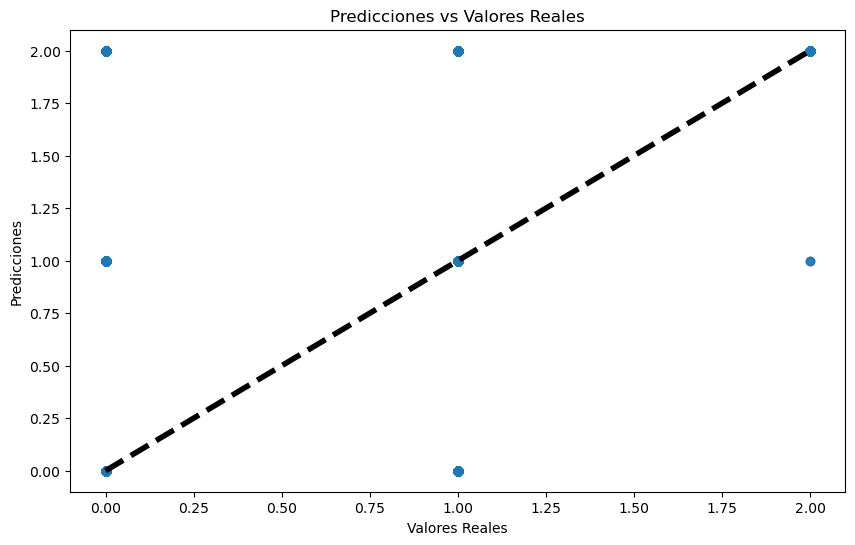

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Valores Reales'], results_df['Predicciones'], alpha=0.5)
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([results_df['Valores Reales'].min(), results_df['Valores Reales'].max()], 
         [results_df['Valores Reales'].min(), results_df['Valores Reales'].max()], 
         'k--', lw=4)  # Línea de identidad
plt.show()

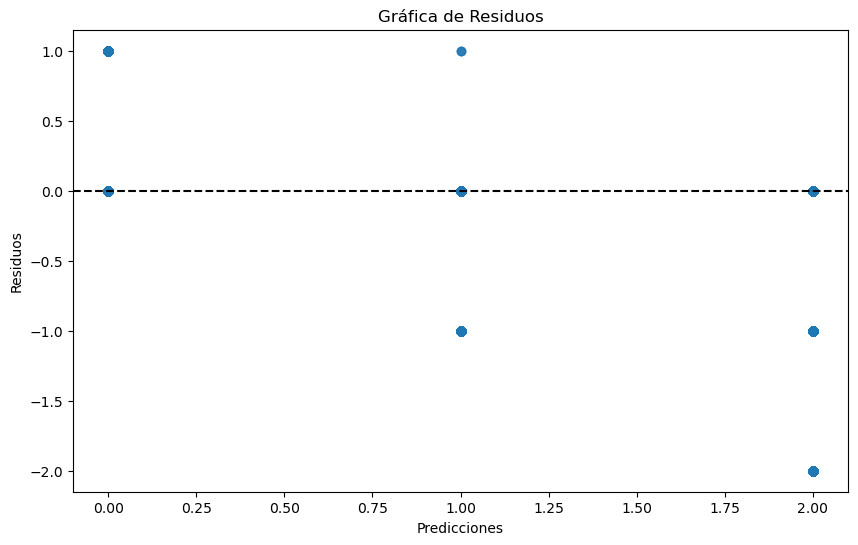

In [27]:
# Calcular residuos
results_df['Residuos'] = results_df['Valores Reales'] - results_df['Predicciones']

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Predicciones'], results_df['Residuos'], alpha=0.5)
plt.title('Gráfica de Residuos')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.axhline(y=0, color='k', linestyle='--')  # Línea horizontal en y=0
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Asumiendo que 'preds' son tus predicciones y 'y_test' los valores reales
cm = confusion_matrix(y_test, preds)

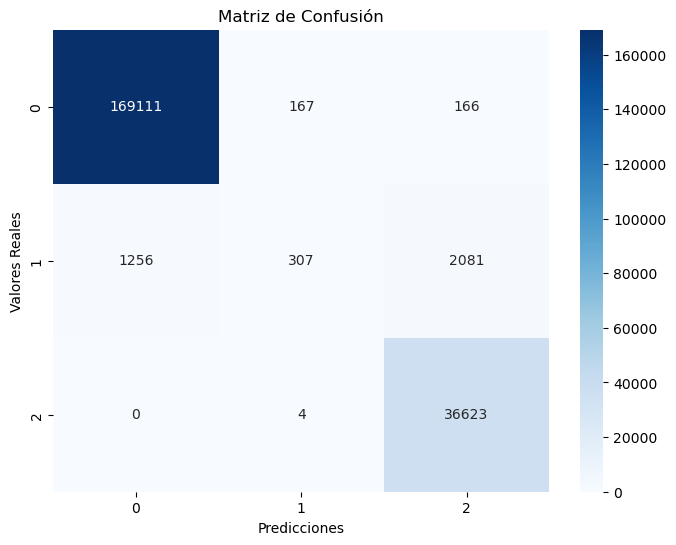

In [29]:

# Etiquetas para los ejes basadas en las clases únicas de tus predicciones/valores reales
labels = sorted(np.unique(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

In [30]:
from sklearn.metrics import classification_report

In [31]:
# Asumiendo que 'preds' son tus predicciones y 'y_test' los valores reales
report = classification_report(y_test, preds, target_names=labels)
print(report)

TypeError: object of type 'numpy.int64' has no len()